# pyNetworkPlot

In [1]:
import sys, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from polyleven import levenshtein as poly_lev
#from collections import defaultdict
import igraph as ig
import random # layout seed
import cairo as cr
from igraph.drawing.text import TextDrawer
from math import pi # Legend circles

In [2]:
module_path = os.path.abspath(os.path.join('..', 'bin'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
# from ../bin
import spring_functions as kxs
from data_functions import group_with_freq
from drawing import *

## Parameters

In [4]:
pd.set_option('display.max_columns',None)

#### Data parameters

In [5]:
out_file = '../results/NETWORK_PLOT.pdf'
seq_col = 'sequence'
color_col = 'color'
shape_col = 'shape'
size_col = 'size'
#min_seq2show = 0 # integer
group_unique = True # Boolean

#### Figure parameters

In [6]:
# Similarity threshold
similarity = 0 # non-negative integer
max_node_size=50
min_node_size=5
layout_name = 'FR' # Can be FR, DH, DrL, GO, LgL, MDS
legend = True
unit=50
edge_width = 1.5

In [7]:
in_file = '../data/test_data.tsv'
file_type = in_file.split('.')[-1]
if file_type == 'tsv':
    DF = pd.read_csv(in_file,sep='\t',index_col=0).reset_index(drop=True)
elif file_type == 'xlsx':
    DF = pd.read_excel(in_file,index_col=0)
elif file_type == 'csv':
    DF = pd.read_csv(in_file,sep=',',index_col=0).reset_index(drop=True)
else:
    raise NameError("Invalid input format. Has to be either .tsv, .csv or .xlsx.")

In [8]:
DF = group_with_freq(DF,seq_col,\
                     group_unique).sort_values(['freq_'+seq_col,seq_col],\
                                               ascending=False).reset_index(drop=True)
DF.loc[DF['group_'+seq_col]==-1,'group_'+seq_col]=DF['group_'+seq_col].max()+1
DF

,sequence,color,shape,size,freq_sequence,group_sequence
0,GCTTCCGTTGCTCTTT,4,MUSL,8,6,0
1,GCTTCCGTTGCTCTTT,4,PB,7,6,0
2,GCTTCCGTTGCTCTTT,3,PB,8,6,0
3,GCTTCCGTTGCTCTTT,8,MUSL,15,6,0
4,GCTTCCGTTGCTCTTT,7,BM,7,6,0
...,...,...,...,...,...,...
145,CCGTAGACTTTT,7,BM,15,1,45
146,AGTCCGACTCATCTGA,9,MUSL,6,1,45
147,AGTAGGATAGTTCCCTAGCG,10,PB,3,1,45
148,ACGCACCATCCCAGGGTTTAGC,6,BM,9,1,45


# II. Distance matrix calculation

In [9]:
seqs = DF[seq_col].values
#idx2seq = {i:seq for i,seq in enumerate(seqs)}
L = len(seqs)
dist = np.zeros([L,L])
t = np.ceil(L/100)
for i in range(L):
    for j in range(L):
        dist[i,j]=poly_lev(seqs[i],seqs[j])
    if i%t==0:
        print("%.2f %% completed"%(i*100/L))

0.00 % completed
1.33 % completed
2.67 % completed
4.00 % completed
5.33 % completed
6.67 % completed
8.00 % completed
9.33 % completed
10.67 % completed
12.00 % completed
13.33 % completed
14.67 % completed
16.00 % completed
17.33 % completed
18.67 % completed
20.00 % completed
21.33 % completed
22.67 % completed
24.00 % completed
25.33 % completed
26.67 % completed
28.00 % completed
29.33 % completed
30.67 % completed
32.00 % completed
33.33 % completed
34.67 % completed
36.00 % completed
37.33 % completed
38.67 % completed
40.00 % completed
41.33 % completed
42.67 % completed
44.00 % completed
45.33 % completed
46.67 % completed
48.00 % completed
49.33 % completed
50.67 % completed
52.00 % completed
53.33 % completed
54.67 % completed
56.00 % completed
57.33 % completed
58.67 % completed
60.00 % completed
61.33 % completed
62.67 % completed
64.00 % completed
65.33 % completed
66.67 % completed
68.00 % completed
69.33 % completed
70.67 % completed
72.00 % completed
73.33 % completed


In [10]:
# Definite adjacency and weight matrices
eps = 0.1 # Distance delta
adj = dist.copy()
adj[adj<=similarity]=-1
adj[adj>similarity]=0
adj[adj==-1]=1
W = np.multiply(adj,dist+eps)

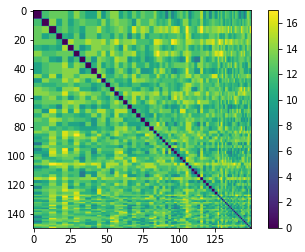

In [11]:
plt.imshow(dist)
plt.colorbar()

# III. Graph generation and plotting

In [12]:
# Create graph object
g = ig.Graph.Weighted_Adjacency(W,mode='undirected',attr='distance',loops=False)

### Node metadata

In [13]:
# Assigns a cluster value based on connected subgraphs. Useful for spring weight
g.vs['cluster'] = DF.loc[:,'group_'+seq_col]
g.vs['freq'] = DF.loc[:,'freq_'+seq_col]

### Node color
Define the fields `plot_label`, which will be the label in the legend of the plot, and `color` for each node. Depending on the type of label, the colouring and the labels will be different.

In [14]:
color_label = DF.loc[:,color_col].values
## COLOR PALETTE ##
# Define unique group labels
_, idx = np.unique(color_label,return_index=True)
labs = color_label[np.sort(idx)]
n_colors = len(labs)
# Create color pallete based on number of groups
pal = ig.drawing.colors.ClusterColoringPalette(n_colors)
label2RGB = {l:pal.get_many(c)[0] for c,l in enumerate(labs)} # Numbering each label
g.vs['color'] = [label2RGB[l] for l in color_label]

### Node shape

In [15]:
shapes = ['circle','rectangle','triangle-up','triangle-down','diamond']

In [16]:
shape_labels = DF[shape_col].unique()
n_shapes = len(shape_labels)
if n_shapes > 5:
    raise ValueError('There can not be more than 5 shapes.')
else:
    shapes = shapes[:n_shapes]
    shape_dic = {shape_labels[i]:shapes[i] for i in range(n_shapes)}

In [17]:
g.vs['shape'] = DF.loc[:,shape_col].replace(shape_dic)

### Node size

In [18]:
if size_col==None:
    S = 20
else:
    S = DF[size_col].values
    S = (S-np.min(S))/(np.max(S)-np.min(S))*(max_node_size-min_node_size)+min_node_size
g.vs['size'] = S

### Graph layout
Creates a layout with the algorithm given by the keyword `layout_name` 

In [19]:
# Initialize layout with a seed (reproducibility)
#random.seed(42)
np.random.seed(42)
layout_seed = np.random.random([len(g.vs),2])

# ToDo: Implement MDS and LgL

In [20]:
# Reingold-Fruchterman
if layout_name == 'FR':
    niter = 5000
    weights = kxs.prop_log_weights(g)
    g.es['weights'] = weights
    l = g.layout_fruchterman_reingold(weights=weights,\
                                      seed=layout_seed,niter=niter)
# Davidson-Harel
elif layout_name == 'DH':
    maxiter = 80
    fineiter = 15
    cool_fact = 0.95
    weight_node_dist = 1000
    weight_border = 20000000
    weight_edge_lengths = 0.1
    weight_edge_crossings = 1000
    weight_node_edge_dist = 10000
    l = g.layout_davidson_harel(seed=layout_seed, maxiter=maxiter, fineiter=fineiter,\
                                       cool_fact=cool_fact, weight_node_dist=weight_node_dist,\
                                       weight_border=weight_border,\
                                       weight_edge_lengths=weight_edge_lengths,\
                                       weight_edge_crossings=weight_edge_crossings,\
                                       weight_node_edge_dist=weight_node_edge_dist)
# Graphopt
elif layout_name == 'GO':
    niter = 500
    node_charge = 0.03
    node_mass = 5
    spring_length = 5
    spring_constant = 0.5
    max_sa_movement = 12
    l = g.layout_graphopt(niter=niter, node_charge=node_charge, node_mass=node_mass,\
                          spring_length=spring_length, spring_constant=spring_constant,\
                          max_sa_movement=max_sa_movement, seed=layout_seed)

In [21]:
g.get_vertex_dataframe()

,cluster,freq,color,shape,size
vertex ID,,,,,
0,0,6,"(1.0, 0.0, 0.0, 1.0)",circle,23.75
1,0,6,"(1.0, 0.0, 0.0, 1.0)",rectangle,20.00
2,0,6,"(0.0, 1.0, 0.0, 1.0)",rectangle,23.75
3,0,6,"(0.0, 0.0, 1.0, 1.0)",circle,50.00
4,0,6,"(1.0, 1.0, 0.0, 1.0)",triangle-up,20.00
...,...,...,...,...,...
145,45,1,"(1.0, 1.0, 0.0, 1.0)",triangle-up,50.00
146,45,1,"(1.0, 0.0, 1.0, 1.0)",circle,16.25
147,45,1,"(0.5, 0.0, 0.0, 1.0)",rectangle,5.00


In [22]:
DF[size_col].min()

3

In [23]:
DF[size_col].max()

15

In [24]:
funcs = [draw_circle,draw_square,draw_triangle_up,draw_triangle_down,draw_diamond]

#### Plot generation

In [25]:
# IV. Plot generation
if legend:
    label_h = 0.5*unit
    size = 0.25*unit
    width,height = (24*unit,18*unit)
    # Construct the plot
    plot = ig.Plot(out_file, bbox=(width,height), background="white")
    plot.add(g, bbox=(1*unit, 1*unit, width-7*unit, height-1*unit),layout=l,
             vertex_size=g.vs['size'])
    plot.redraw()
    ctx = cr.Context(plot.surface)
    # Legend rectangle
    n_labels = n_colors + bool(color_col)*1 + n_shapes + bool(shape_col)*1 + 3*bool(shape_col)
    rect_height = label_h*(n_labels+1)
    rect_width = 3*unit # Change if the label is too long/short
    coord = (19*unit,9*unit-rect_height/2) # standing coordinates x,y
    ctx.rectangle(coord[0],coord[1], rect_width, rect_height)
    ctx.set_source_rgb(1, 1, 1)
    ctx.fill_preserve()
    ctx.set_source_rgb(0, 0, 0)
    ctx.set_line_width(2)
    ctx.stroke()
    # Legend items
    coord=(coord[0]+label_h,coord[1] + label_h)
    # Shape items
    if shape_col:
        for s in range(n_shapes):
            funcs[s](ctx,coord,size)
            coord = (coord[0] + 1.5*size,coord[1]+0.85*size)
            draw_text(ctx,str(shape_labels[s]),coord,size)
            coord = (coord[0]-1.5*size,coord[1]+1.15*size)
        coord = (coord[0],coord[1]+size)
    # Color items
    if color_col:
        for l in label2RGB.keys():
            draw_circle(ctx,coord,size,in_color=(label2RGB[l][0],label2RGB[l][1],label2RGB[l][2]),
                       line_color=(label2RGB[l][0],label2RGB[l][1],label2RGB[l][2]))
            coord = (coord[0]+1.5*size,coord[1]+0.85*size)
            draw_text(ctx,str(l),coord,size)
            coord = (coord[0]-1.5*size,coord[1]+1.15*size)
        coord = (coord[0],coord[1]+size)
    # Size items
    if size_col:
        coord= (coord[0]+0.25*size,coord[1]+0.25*size)
        draw_circle(ctx,coord,min_node_size)
        coord = (coord[0]+4.5*size,coord[1]+0.6*size)
        draw_text(ctx,str(DF[size_col].min()),coord,size)
        
        coord = (coord[0]-6.25*size,coord[1]+1.15*size)
        draw_circle(ctx,coord,max_node_size,line_width = 0.05*size)
        coord = (coord[0]+3*label_h,coord[1]+label_h)
        draw_text(ctx,str(DF[size_col].max()),coord,size)
    # Save the plot
    plot.save()
else:
    visual_style = {
        'bbox' : (0, 0, 600, 600),
        'layout' : l,
        "margin": 20,
        "autocurve" : False
        #'edge_width' : g.es['width'],
    }
    ig.plot(g,target=out_file,**visual_style)